# Project Title

## Overview
Lorem ipsum dolor sit amet

## Setup

### Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
import os.path
import zipfile
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Import Dataset

In [2]:
# Authenticate with your Kaggle credentials
api = KaggleApi()
api.authenticate()

# Specify the dataset name
dataset_name = 'online-payments-fraud-detection-dataset'
dataset_folder_path = './data/'
kaggle_dataset_path = 'rupakroy/' + dataset_name

if os.path.isfile(dataset_folder_path + dataset_name + '.csv'):
    print("Found dataset archive.")
else:
    # Download the dataset files
    print("Downloading dataset from Kaggle.")
    api.dataset_download_files(kaggle_dataset_path, path=dataset_folder_path, unzip=True)
    # Specify the path to the zip file
    zip_file_path = dataset_folder_path + dataset_name + '.zip'

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the specified directory
        zip_ref.extractall(dataset_folder_path)

    # Delete the zip file
    os.remove(zip_file_path)
    for filename in zip_ref.namelist():
        new_filename = dataset_name + '.csv'
        old_filepath = os.path.join(dataset_folder_path, filename)
        new_filepath = os.path.join(dataset_folder_path, new_filename)
        os.rename(old_filepath, new_filepath)
    print("Downloaded dataset from Kaggle.")

df = pd.read_csv(dataset_folder_path + dataset_name + '.csv')
# ake a copy to preserve the original data
dff = df.copy()

Found dataset archive.


## Data Preprocessing

### Check for empty data

In [3]:
if dff.isnull().values.any():
    print("Error: Missing data")
else:
    print("No missing values found.")

No missing values found.


### Check for correct data types

In [4]:
# Print datatypes of features to ensure they are the correct type
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Drop irrelevant columns

In [5]:
dff = dff.drop('isFlaggedFraud', axis=1)
print(dff.columns)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')


### Rename Columns

In [6]:
dff.columns = ['Transaction_Hours','Type','Transaction_Amount','Sender','Sender_Balance_Previous_Transaction','Sender_Balance_After_Transaction','Receiver','Receiver_Balance_Previous_Transaction','Receiver_Balance_After_Transaction','isFraud']

### Pick Numerical Features

In [7]:
# Pick features with numerical value, excluding the class column
features = ['Transaction_Hours','Transaction_Amount', 'Sender_Balance_Previous_Transaction','Sender_Balance_After_Transaction','Receiver_Balance_Previous_Transaction','Receiver_Balance_After_Transaction']
numerical_features = dff[features]

### Check for skewed distributions

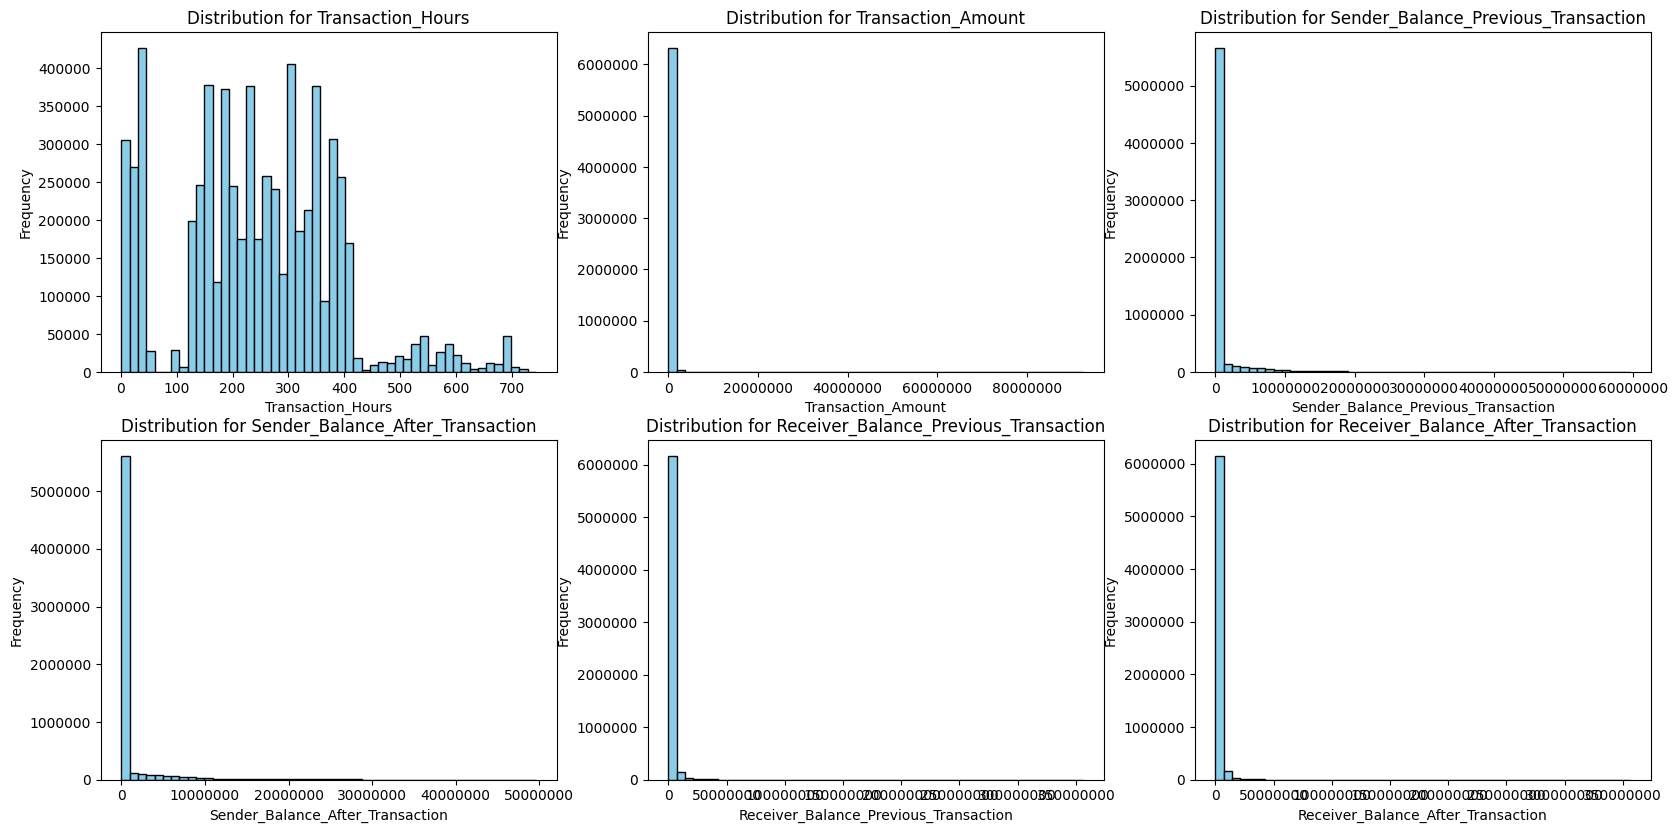

In [8]:
plt.figure(figsize=(20,15))

# Create separate histograms with density plots for each numerical column
for i, feature in enumerate(features, 1):
    # plt.figure(figsize=(10, 6))
    plt.subplot(3, 3, i)
    plt.hist(dff[feature], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Distribution for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.ticklabel_format(style='plain', axis='x')
    plt.ticklabel_format(style='plain', axis='y')

plt.show()

### Remove outliers

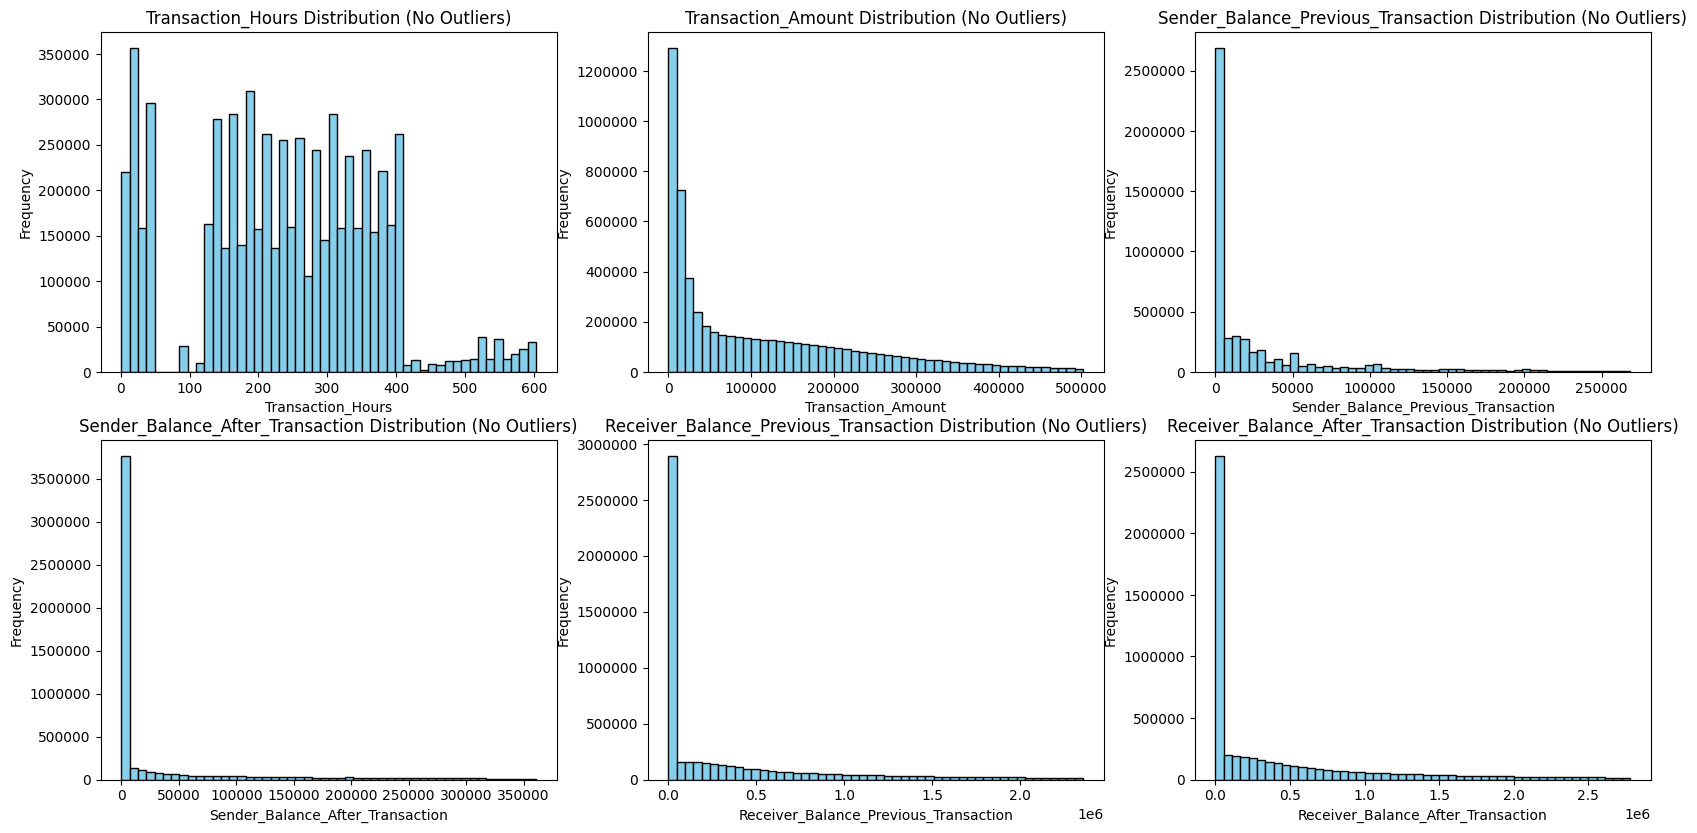

In [9]:
plt.figure(figsize=(20,15))

# Create separate histograms with density plots for each numerical column
for i, feature in enumerate(features, 1):
    # Calculate the IQR
    Q1 = dff[feature].quantile(0.25)
    Q3 = dff[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify and filter out outliers
    df_no_outliers = dff[(dff[feature] >= lower_bound) & (dff[feature] <= upper_bound)]

    # Plot histogram of Transaction Amount after removing outliers
    plt.subplot(3, 3, i)
    plt.hist(df_no_outliers[feature], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'{feature} Distribution (No Outliers)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.ticklabel_format(style='plain', axis='y')
    plt.ticklabel_format(style='plain', axis='y')


### Check for Class Imbalance

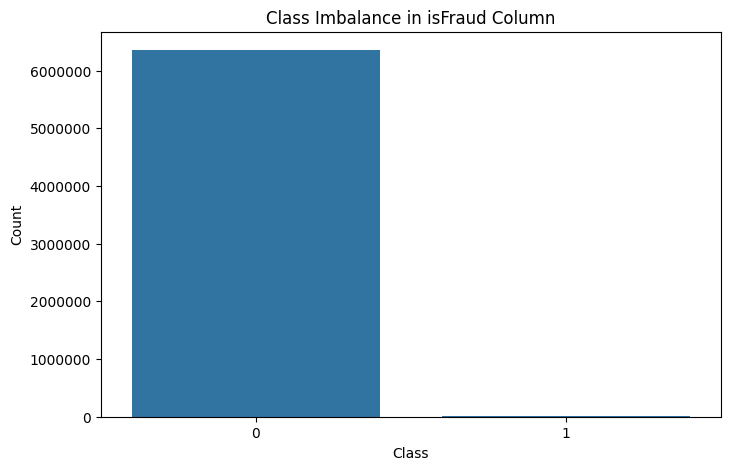

In [10]:
# Set the figure size
plt.figure(figsize=(8, 5))

# Plot the class imbalance
sns.countplot(x='isFraud', data=dff)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Class Imbalance in isFraud Column')

# Show the plot
plt.show()

In [15]:
### Undersample data

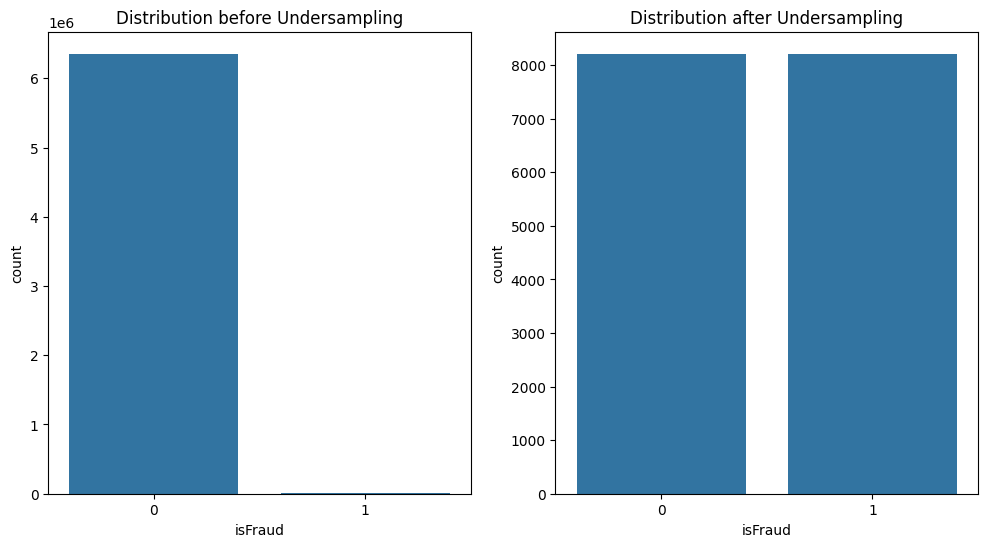

In [22]:
# Perform undersampling on the majority class
features = numerical_features
target = dff['isFraud']

undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
features_resampled, target_resampled = undersampler.fit_resample(features, target)

# Plot the distribution before and after undersampling
plt.figure(figsize=(12, 6))

# Plot the distribution before undersampling
plt.subplot(1, 2, 1)
sns.countplot(x=target)
plt.title('Distribution before Undersampling')

# Plot the distribution after undersampling
plt.subplot(1, 2, 2)
sns.countplot(x=target_resampled)
plt.title('Distribution after Undersampling')

plt.show()


### Oversample the data

AttributeError: This method only works with the ScalarFormatter

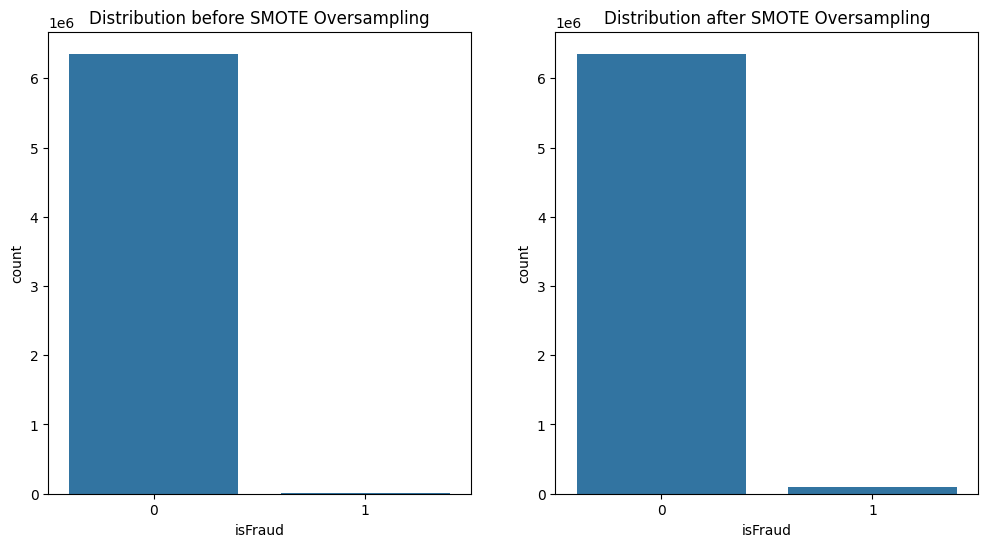

In [30]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dff' is your DataFrame and 'isFraud' is the binary target variable
features = numerical_features  # Your numerical features as a DataFrame
target = dff['isFraud']

# Initialize SMOTE with a specific sampling strategy. The exact strategy may depend on the current class distribution.
desired_samples = 100000
current_minority_samples = target.value_counts().min()  # Get the current number of samples in the minority class

# Calculate the ratio for the minority class to achieve the desired number of samples.
# This assumes '0' is the majority class and '1' is the minority class.
sampling_strategy = {0: target.value_counts()[0], 1: desired_samples}

# Initialize SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Apply SMOTE oversampling on the data
features_resampled_smote, target_resampled_smote = smote.fit_resample(features, target)

# Plot the distribution before and after SMOTE oversampling
plt.figure(figsize=(12, 6))

# Plot the distribution before SMOTE oversampling
plt.subplot(1, 2, 1)
sns.countplot(x=target)
plt.title('Distribution before SMOTE Oversampling')
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

# Plot the distribution after SMOTE oversampling
plt.subplot(1, 2, 2)
sns.countplot(x=target_resampled_smote)
plt.title('Distribution after SMOTE Oversampling')
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

# Check the number of samples after SMOTE
print("Number of samples per class after SMOTE:")
print(target_resampled_smote.value_counts())